In [3]:
import cv2
import numpy as np
import time
import math
import datetime
import pyautogui
import matplotlib.pyplot as plt
from eyeGestures.utils import VideoCapture
from eyeGestures import EyeGestures_v3

In [9]:
def average_laplacian(image):
    """Applies an average filter followed by a Laplacian filter."""
    kernel_size = (3, 3)  # Define kernel size for averaging
    average_filtered = cv2.blur(image, kernel_size)

    # Convert image to float64 for Laplacian
    image = image.astype(np.float64)  # Use np.float64 for the Laplacian filter

    # Apply the Laplacian filter
    laplacian_filtered = cv2.Laplacian(image, cv2.CV_64F)

    # Enhance the image
    enhanced_image = laplacian_filtered - average_filtered

    # Convert back to uint8 (clip to valid range)
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)

    return enhanced_image

def preprocess_image(img_array,color, target_size):
    """
    Preprocess a batch of images:
    - Convert each image in the batch to grayscale.
    - Resize each image to the target size.
    Args:
        img_array (np.array): Input batch of images (batch_size, H, W, C).
        target_size (tuple): Desired target size (width, height).
    Returns:
        np.array: Preprocessed grayscale images of target size (batch_size, H', W').
    """
    if img_array is None or img_array.size == 0:
        raise ValueError("Input image array is empty or None.")

    # Ensure the input image has the correct shape
    if img_array.ndim == 3 and img_array.shape[-1] == 1:
        img_array = img_array.squeeze(-1)  # Remove the single channel -> (H, W)

    #laplacian_img = average_laplacian(img_array)  # Apply Laplacian filter

    laplacian_img =cv2.threshold(img_array, 4, 255, cv2.THRESH_BINARY)[1]

    if color is False:
        #grayscale_img = cv2.threshold(laplacian_img, 0, 255, cv2.THRESH_BINARY)[1]
        grayscale_img = cv2.cvtColor(laplacian_img, cv2.COLOR_RGB2GRAY)  # Already grayscale
        grayscale_img = cv2.equalizeHist(grayscale_img)  # Histogram equalization
        resized_img = cv2.resize(grayscale_img, target_size, interpolation=cv2.INTER_AREA)
        resized_img = np.expand_dims(resized_img, axis=-1)
    else:
      grayscale_img = laplacian_img
      resized_img = cv2.resize(grayscale_img, target_size, interpolation=cv2.INTER_AREA)

    return resized_img

Primary screen size: 1920x1080


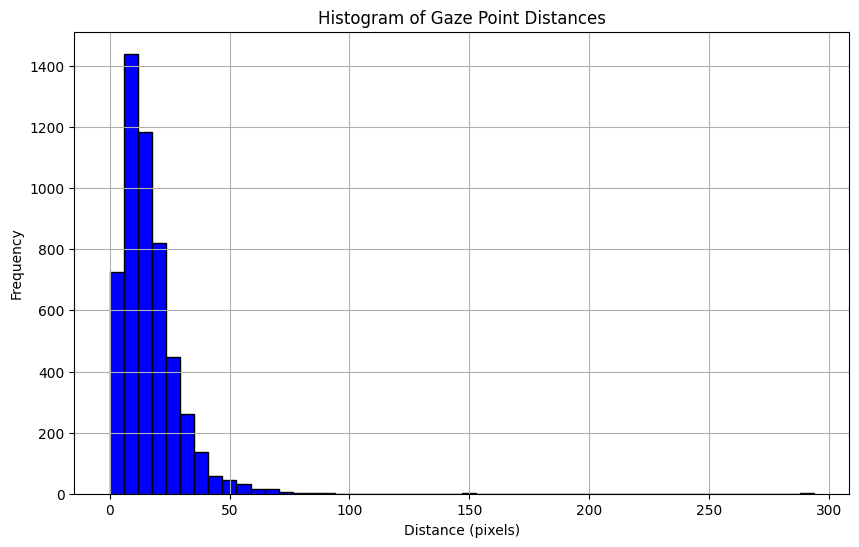

In [12]:
# Initialize gesture engine and video capture
gestures = EyeGestures_v3()
cap = VideoCapture(0)
calibrate = True
# screen_width = 640
# screen_height = 480
screen_width, screen_height = pyautogui.size()
print(f"Primary screen size: {screen_width}x{screen_height}")

x = np.arange(0, 1.1, 0.2)
y = np.arange(0, 1.1, 0.2)

xx, yy = np.meshgrid(x, y)

calibration_map = np.column_stack([xx.ravel(), yy.ravel()])
n_points = min(len(calibration_map),25)
np.random.shuffle(calibration_map)
gestures.uploadCalibrationMap(calibration_map,context="my_context")
gestures.setFixation(1.0)

# Create a blank image to draw the scanpath on
scanpath_img = np.zeros((screen_height, screen_width, 3), dtype=np.uint8)

# Store previous point to draw lines
prev_point = None
distances = []

# Start time
start_time = time.time()
duration = 300  # seconds

# Process each frame
try:
    while True:
        if time.time() - start_time > duration:
            break

        ret, frame = cap.read()
        if not ret:
            break
        try:
            event, cevent = gestures.step(frame, calibrate, screen_width, screen_height, context="my_context")

            if event:
                if int(event.point[0]) != 0 and int(event.point[1]) != 0:
                    current_point = (int(event.point[0]), int(event.point[1]))

                    if prev_point is not None:
                        dist = math.dist(prev_point, current_point)
                        distances.append(dist)

                        #if dist < 100:  # Filter out jumps
                        cv2.line(scanpath_img, prev_point, current_point, color=(0, 255, 0), thickness=2)
                # if prev_point[1]==current_point[1] and abs(prev_point[0]-current_point[0])<50:
                    prev_point = current_point

        except Exception as e:
            print(f"Error processing frame: {e}")
            continue

    processed_image = preprocess_image(scanpath_img, color=False, target_size=(224,224))

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"scanpath_{timestamp}.png"
    cv2.imwrite(filename, processed_image)

finally:
    cap.close()

# Plot the histogram of distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Gaze Point Distances')
plt.xlabel('Distance (pixels)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [8]:
preprocess_image(scanpath_img, color=False, target_size=(224,224))